In [1]:
import os
import json
import hashlib
import numpy as np
from qcelemental import constants
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 14})
from functions import zetacolors, extrapolations, getFuncPars, prettifyBasis, prettifyFunc

In [2]:
with open(os.path.join("..", "external", "gmtkn.json"), "r") as infile:
    storeddata = json.load(infile)
    suite = storeddata["suites"]["diet100"]
    reactions = storeddata["reactions"]
    psi4data = storeddata["data"]
dbpath = os.path.join("..", "data", "ASCDB")

In [3]:
functionals = [
    "blyp-d3bj", "pbe-d3bj", "revpbe-d3bj", "b97-d3bj", "scan-d3bj", "m06l-d3", "b97m-v", "b97m-d3bj",
    "b3lyp-d3bj", "wb97x-v", "m052x-d3", "dldf+d10", 
    "dsd-blyp-d3bj", "b2plyp-d3bj", "pwpb95-nl", "pbe0dh-d3bj"
]
bfamily = [
    ["cc-pvdz-pp", "cc-pvtz-pp", "cc-pvqz-pp", "cc-pv5z-pp"],
    ["def2-svp", "def2-tzvp", "def2-qzvp"],
    ["def2-svpd", "def2-tzvpd", "def2-qzvpd"],
    ["pcseg-1","pcseg-2","pcseg-3"]
]
xtplbases = [
    ["cc-pv[dt]z-pp", "cc-pv[tq]z-pp"],
    ["def2-[st]zvp", "def2-[tq]zvp"],
    ["def2-[st]zvpd", "def2-[tq]zvpd"],
    ["pcseg-[12]","pcseg-[23]"],
]
bases = [item for sublist in bfamily for item in sublist]

In [4]:
for bname in psi4data.keys():
    for species in psi4data[bname]:
        for func in psi4data[bname][species].keys():
            try: 
                ax, ac = getFuncPars(func)
            except ValueError:
                continue
            if species == "charge":
                continue
            for xtpl in extrapolations:
                if len(set(psi4data[bname][species][func].keys()).intersection(extrapolations[xtpl]["comps"])) != 2:
                    continue
                Zlo = extrapolations[xtpl]["zetas"][0]
                Zhi = extrapolations[xtpl]["zetas"][1]
                α = extrapolations[xtpl]["α0"] + ax * extrapolations[xtpl]["αx"] + ac * extrapolations[xtpl]["αc"]
                Elo = psi4data[bname][species][func][extrapolations[xtpl]["comps"][0]]["fctl"] - psi4data[bname][species][func][extrapolations[xtpl]["comps"][0]]["nl"]
                Ehi = psi4data[bname][species][func][extrapolations[xtpl]["comps"][1]]["fctl"] - psi4data[bname][species][func][extrapolations[xtpl]["comps"][1]]["nl"]
                b_div = 1 / (np.exp(-1 * α * np.sqrt(Zhi)) - np.exp(-1 * α * np.sqrt(Zlo)))
                b_mul = np.exp(-1 * α * np.sqrt(Zhi))
                b = (Ehi - Elo) * b_div
                Efctl = Ehi - b * b_mul
                α = extrapolations[xtpl]["αdh"]
                Elo = psi4data[bname][species][func][extrapolations[xtpl]["comps"][0]]["dh"]
                Ehi = psi4data[bname][species][func][extrapolations[xtpl]["comps"][1]]["dh"]
                b_div = 1 / (Zhi**(-1 * α) - Zlo**(-1 * α))
                b_mul = Zhi**(-1 * α)
                b = (Ehi - Elo) * b_div
                Edh = Ehi - b * b_mul
                Edisp = psi4data[bname][species][func][extrapolations[xtpl]["comps"][1]]["disp"]
                Enl = psi4data[bname][species][func][extrapolations[xtpl]["comps"][1]]["nl"]
                psi4data[bname][species][func][xtpl] = {"total": Efctl + Edh + Edisp + Enl}
                    

In [5]:
gmtkn55 = {}
for func in functionals:
    gmtkn55[func] = {}
    for basis in bases:
        gmtkn55[func][basis] = []
    for basis in extrapolations:
        gmtkn55[func][basis] = []

In [6]:
for func in gmtkn55.keys():
    for basis in gmtkn55[func].keys():
        for bname, bpars in suite.items():
            w = bpars["w"]
            for reacind in bpars["i"]:
                reaction = reactions[bname][f"{reacind}"]
                Eref = reaction["ref"] * constants.cal2J
                Ecalc = 0
                success = True
                for i in range(len(reaction["species"])):
                    species = reaction["species"][i]
                    stoich = reaction["stoich"][i]
                    if func in psi4data[bname][species] and basis in psi4data[bname][species][func]:
                        Ecalc += stoich * psi4data[bname][species][func][basis]["total"]
                    else:
                        success = False
                if success:
                    dE = abs(Eref - Ecalc * constants.hartree2kJmol)
                    if dE < 10000:
                        gmtkn55[func][basis].append(dE * w)
                else:
                    pass
                #print(reaction, basis, func)

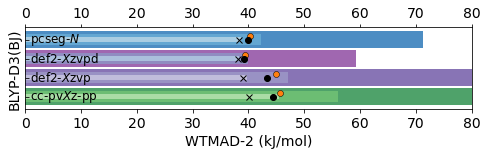

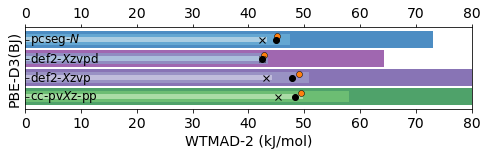

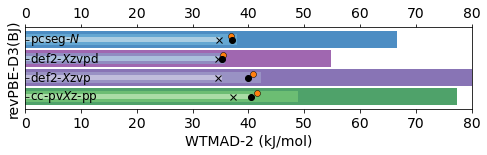

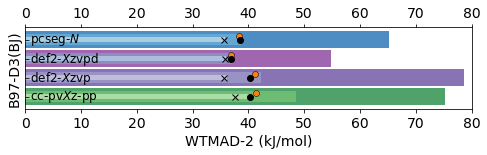

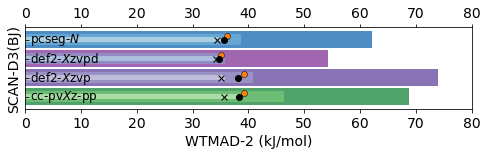

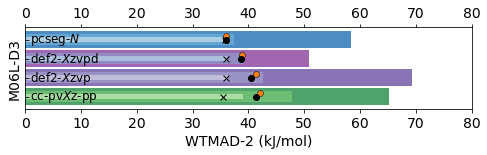

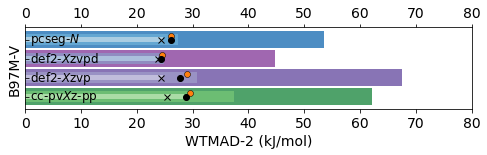

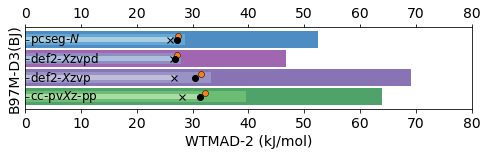

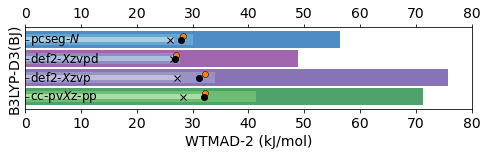

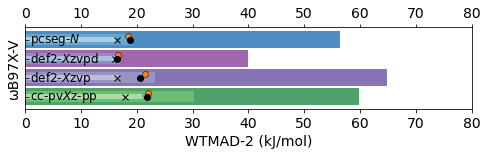

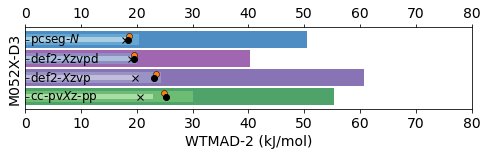

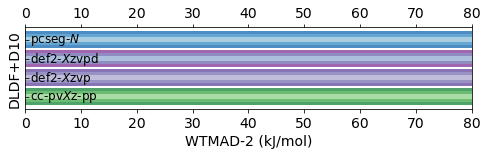

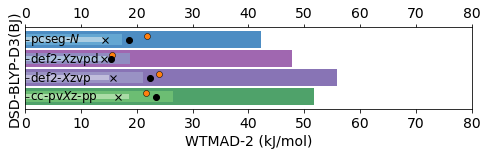

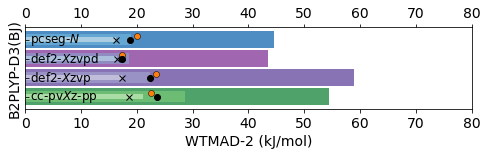

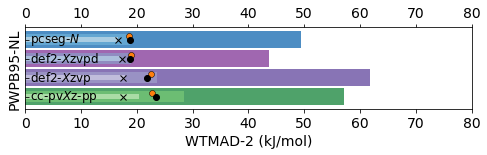

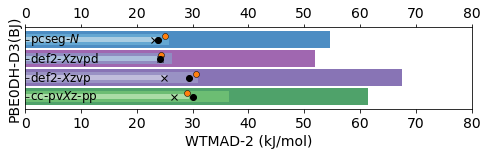

In [7]:
i = 0
for func in functionals:
    fig, ax = plt.subplots(figsize=(8,1.5))
    yticks = []
    for y in range(len(bfamily)):
        yticks.append(f'{prettifyBasis(bfamily[y][-1])}')
        for bi in range(len(bfamily[y])):
            basis = bfamily[y][bi]
            z = bi+2
            ax.barh(y, np.mean(gmtkn55[func][basis]), color=zetacolors[basis], 
                    edgecolor="k", linewidth=0.0, height=0.9-0.3*bi, zorder=1, alpha=0.8)
    for y in range(len(xtplbases)):
        for bi in range(len(xtplbases[y])):
            basis = xtplbases[y][bi]
            ax.plot(np.mean(gmtkn55[func][basis]), y, 
                    marker=("o" if bi == 0 else "x"), color="k", zorder=3)
    ax.plot(np.mean(gmtkn55[func]["cc-pv[dt]z-pp-v1"]), 0 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax.plot(np.mean(gmtkn55[func]["def2-[st]zvp-v1"]), 1 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax.plot(np.mean(gmtkn55[func]["def2-[st]zvpd-v1"]), 2 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax.plot(np.mean(gmtkn55[func]["pcseg-[12]-v1"]), 3 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax.set_ylabel(prettifyFunc(func))
    ax.set_xlim(left=0, right=80)
    ax.tick_params(axis="y",direction="in", pad=-5)
    ax.set_yticks(range(len(yticks)))
    ax.set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
    ax.tick_params(top=True, bottom=True, labeltop=True, labelbottom=True)
    ax.set_xlabel("WTMAD-2 (kJ/mol)")
    fig.savefig(os.path.join("..","output",f"fig_gmtkn55_{i:02d}.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")
    i += 1

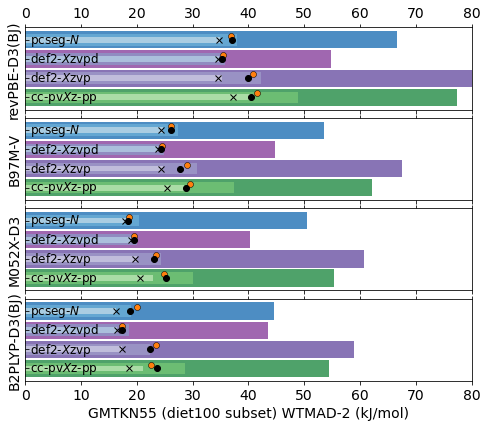

In [8]:
fig, ax = plt.subplots(figsize=(8,6.5))
grid = plt.GridSpec(4, 1, wspace=0.1, hspace=0.1, figure=fig)
ax = []
ax.append(plt.subplot(grid[0:1, :]))
ax.append(plt.subplot(grid[1:2, :]))
ax.append(plt.subplot(grid[2:3, :]))
ax.append(plt.subplot(grid[3:4, :]))
ai = 0
for func in ["revpbe-d3bj", "b97m-v", "m052x-d3", "b2plyp-d3bj"]:
    yticks = []
    for y in range(len(bfamily)):
        yticks.append(f'{prettifyBasis(bfamily[y][-1])}')
        for bi in range(len(bfamily[y])):
            basis = bfamily[y][bi]
            z = bi+2
            ax[ai].barh(y, np.mean(gmtkn55[func][basis]), color=zetacolors[basis], 
                    edgecolor="k", linewidth=0.0, height=0.9-0.3*bi, zorder=1, alpha=0.8)
    for y in range(len(xtplbases)):
        for bi in range(len(xtplbases[y])):
            basis = xtplbases[y][bi]
            ax[ai].plot(np.mean(gmtkn55[func][basis]), y, 
                    marker=("o" if bi == 0 else "x"), color="k", zorder=3)
    ax[ai].plot(np.mean(gmtkn55[func]["cc-pv[dt]z-pp-v1"]), 0 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax[ai].plot(np.mean(gmtkn55[func]["def2-[st]zvp-v1"]), 1 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax[ai].plot(np.mean(gmtkn55[func]["def2-[st]zvpd-v1"]), 2 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax[ai].plot(np.mean(gmtkn55[func]["pcseg-[12]-v1"]), 3 + 0.2, 
            marker="o", color="C1", markeredgecolor="k", markeredgewidth=0.5)
    ax[ai].set_ylabel(prettifyFunc(func))
    ax[ai].set_xlim(left=0, right=80)
    ax[ai].tick_params(axis="y",direction="in", pad=-5)
    ax[ai].set_yticks(range(len(yticks)))
    ax[ai].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
    if ai == 0:
        ax[ai].tick_params(top=True, bottom=True, labeltop=True, labelbottom=False)
    elif ai == 3:
        ax[ai].tick_params(top=True, bottom=True, labeltop=False, labelbottom=True)
        ax[ai].set_xlabel("GMTKN55 (diet100 subset) WTMAD-2 (kJ/mol)")
    else:
        ax[ai].tick_params(top=True, bottom=True, labeltop=False, labelbottom=False)
    ai += 1
fig.savefig(os.path.join("..","output","fig_gmtkn55_sel.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

In [9]:
psi4data.keys()
# NCI:      dt: near q performance;             tq: better than q
# Thermo:   dt: near q performance;             tq: marginal over q
# NLE:      dt: poor, especially with DH;       tq: marginal over q, poor with DH
# Unbiased: dt: better than t, not good for DH; tq: better than q, not good for DH

dict_keys(['INV24', 'YBDE18', 'CARBHB12', 'ALK8', 'S22', 'PA26', 'CDIE20', 'ICONF', 'BHDIV10', 'C60ISO', 'IDISP', 'SCONF', 'SIE4x4', 'BSR36', 'BUT14DIOL', 'WATER27', 'CHB6', 'RSE43', 'ACONF', 'S66', 'BHPERI', 'W4-11', 'G21IP', 'ALKBDE10', 'MCONF', 'BHROT27', 'ISOL24', 'NBPRC', 'PNICO23', 'RC21', 'ADIM6', 'BH76', 'G2RC', 'UPU23', 'ISO34', 'AL2X6', 'PX13', 'TAUT15', 'DC13', 'HEAVY28', 'RG18', 'HEAVYSB11', 'DIPCS10', 'PCONF21', 'Amino20x4', 'IL16', 'FH51', 'BH76RC', 'AHB21', 'G21EA', 'WCPT18', 'DARC', 'HAL59', 'MB16-43', 'PArel'])

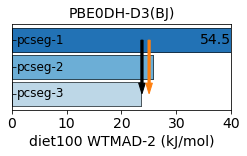

In [10]:
fig  = plt.figure(figsize=(10/2.54,4/2.54))
axes = []
fi = 1
axes.append(plt.subplot(1, 1, fi))
bases = ["pcseg-1","pcseg-2","pcseg-3"]

func = "pbe0dh-d3bj"
data = [np.mean(gmtkn55["pbe0dh-d3bj"][i]) for i in bases]
colors = [zetacolors[i] for i in bases]
for basis in ["pcseg-1", "pcseg-2", "pcseg-3"]:
    axes[0].barh([2,1,0], data, color=colors,
                    edgecolor="k", linewidth=0.5, height=0.9, zorder=1, alpha=0.8)

axes[0].text(40,2, f"{data[0]:4.1f}", va="center", ha="right")

axes[0].arrow(x = np.mean(gmtkn55[func]["pcseg-[12]"]), y = 2, 
              dx = 0, dy = -2, width=0.4, length_includes_head=True, color="k", head_length=0.4)

axes[0].arrow(x = np.mean(gmtkn55[func]["pcseg-[12]-v1"]), y = 2, 
              dx = 0, dy = -2, width=0.4, length_includes_head=True, color="C1", head_length=0.4)


yticks = bases[::-1]
axes[0].tick_params(axis="y",direction="in", pad=-5)
axes[0].set_yticks(range(len(yticks)))
axes[0].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
axes[0].set_title("PBE0DH-D3(BJ)", fontsize=14)
axes[0].set_xlim(left=0, right=40)
axes[0].set_xlabel("diet100 WTMAD-2 (kJ/mol)")
plt.show()
fig.savefig(os.path.join("..","output","fig_gmtkn_pbe0dh.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

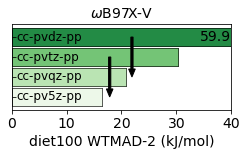

In [11]:
fig  = plt.figure(figsize=(10/2.54,4/2.54))
axes = []
fi = 1
axes.append(plt.subplot(1, 1, fi))
bases = ["cc-pvdz-pp", "cc-pvtz-pp", "cc-pvqz-pp", "cc-pv5z-pp"]

func = "wb97x-v"
data = [np.mean(gmtkn55[func][i]) for i in bases]
colors = [zetacolors[i] for i in bases]
for basis in bases:
    axes[0].barh([3,2,1,0], data, color=colors,
                    edgecolor="k", linewidth=0.5, height=0.9, zorder=1, alpha=0.8)


axes[0].arrow(x = np.mean(gmtkn55[func]["cc-pv[dt]z-pp"]), y = 3, 
              dx = 0, dy = -2, width=0.4, length_includes_head=True, color="k", head_length=0.4)

axes[0].arrow(x = np.mean(gmtkn55[func]["cc-pv[tq]z-pp"]), y = 2, 
              dx = 0, dy = -2, width=0.4, length_includes_head=True, color="k", head_length=0.4)

axes[0].text(40,3, f"{data[0]:4.1f}", va="center", ha="right")

yticks = bases[::-1]
axes[0].tick_params(axis="y",direction="in", pad=-5)
axes[0].set_yticks(range(len(yticks)))
axes[0].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
axes[0].set_title("$\omega$B97X-V", fontsize=14)
axes[0].set_xlim(left=0, right=40)
axes[0].set_xlabel("diet100 WTMAD-2 (kJ/mol)")
plt.show()
fig.savefig(os.path.join("..","output","fig_gmtkn_wb97xv.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")

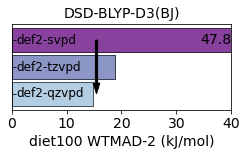

In [12]:
fig  = plt.figure(figsize=(10/2.54,4/2.54))
axes = []
fi = 1
axes.append(plt.subplot(1, 1, fi))
bases = ["def2-svpd", "def2-tzvpd", "def2-qzvpd"]

func = "dsd-blyp-d3bj"
data = [np.mean(gmtkn55[func][i]) for i in bases]
colors = [zetacolors[i] for i in bases]
for basis in bases:
    axes[0].barh([2,1,0], data, color=colors,
                    edgecolor="k", linewidth=0.5, height=0.9, zorder=1, alpha=0.8)
    
axes[0].text(40, 2, f"{data[0]:4.1f}", va="center", ha="right")
axes[0].arrow(x = np.mean(gmtkn55[func]["def2-[st]zvpd"]), y = 2, 
              dx = 0, dy = -2, width=0.4, length_includes_head=True, color="k", head_length=0.4)

yticks = bases[::-1]
axes[0].tick_params(axis="y",direction="in", pad=-5)
axes[0].set_yticks(range(len(yticks)))
axes[0].set_yticklabels(yticks, horizontalalignment = "left", fontsize=12, verticalalignment="center")
axes[0].set_title("DSD-BLYP-D3(BJ)", fontsize=14)
axes[0].set_xlim(left=0, right=40)
axes[0].set_xlabel("diet100 WTMAD-2 (kJ/mol)")
plt.show()
fig.savefig(os.path.join("..","output","fig_gmtkn_dsdblyp.pdf"), dpi=300, format="pdf", pad_inches=0.1, bbox_inches="tight")